In [95]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc


In [5]:
!ls liar_dataset.zip

liar_dataset.zip


In [8]:
!unzip liar_dataset.zip

Archive:  liar_dataset.zip
  inflating: README                  
  inflating: test.tsv                
  inflating: train.tsv               
  inflating: valid.tsv               


In [10]:
!ls

liar_dataset.zip  README  sample_data  test.tsv  train.tsv  valid.tsv


In [31]:
columns = [
    "id", "label", "statement", "subject", "speaker",
    "job", "state", "party",
    "barely_true", "false", "half_true",
    "mostly_true", "pants_fire", "context"
]

train_df = pd.read_csv("train.tsv", sep="\t", names=columns)
valid_df = pd.read_csv("valid.tsv", sep="\t", names=columns)
test_df  = pd.read_csv("test.tsv", sep="\t", names=columns)

fake_labels = ["false", "pants-fire", "barely-true"]
real_labels = ["half-true", "mostly-true", "true"]

def map_label(label):
    if label in fake_labels:
        return 0
    elif label in real_labels:
        return 1
    else:
        return None

train_df["target"] = train_df["label"].apply(map_label)
test_df["target"]  = test_df["label"].apply(map_label)

train_df = train_df.dropna()
test_df  = test_df.dropna()

In [51]:
fake_labels = ["false", "pants-fire", "barely-true"]
real_labels = ["half-true", "mostly-true", "true"]

def map_label(label):
    if label in fake_labels:
        return 0
    elif label in real_labels:
        return 1
    else:
        return None

train_df["target"] = train_df["label"].apply(map_label)
valid_df["target"] = valid_df["label"].apply(map_label)
test_df["target"]  = test_df["label"].apply(map_label)

train_df = train_df.dropna(subset=["target"])
valid_df = valid_df.dropna(subset=["target"])
test_df  = test_df.dropna(subset=["target"])

In [33]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z ]", "", text)
    return text

train_df["statement"] = train_df["statement"].apply(clean_text)
valid_df["statement"] = valid_df["statement"].apply(clean_text)
test_df["statement"]  = test_df["statement"].apply(clean_text)

In [34]:
train_df[["statement", "label"]].head()

,statement,label
0,says the annies list political group supports ...,false
1,when did the decline of coal start it started ...,half-true
2,hillary clinton agrees with john mccain by vot...,mostly-true
5,the chicago bears have had more starting quart...,true
7,im the only person on this stage who has worke...,half-true


In [63]:
vectorizer = TfidfVectorizer(
    stop_words="english",
    max_df=0.7,
    ngram_range=(1, 2)
)

X_train = vectorizer.fit_transform(train_df["statement"])
X_valid = vectorizer.transform(valid_df["statement"])
X_test  = vectorizer.transform(test_df["statement"])

y_train = train_df["target"]
y_valid = valid_df["target"]
y_test  = test_df["target"]


In [64]:
X_train = train_df["statement"]
y_train = train_df["target"]

X_test = test_df["statement"]
y_test = test_df["target"]

In [65]:
print(y_train.value_counts())

target
1    3929
0    2792
Name: count, dtype: int64


In [66]:
vectorizer = TfidfVectorizer(stop_words="english", max_df=0.7)

X_train = vectorizer.fit_transform(X_train)
X_test  = vectorizer.transform(X_test)

In [67]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [68]:
vectorizer = TfidfVectorizer(
    stop_words="english",
    max_df=0.7,
    ngram_range=(1, 2)
)

X_train = vectorizer.fit_transform(train_df["statement"])
X_valid = vectorizer.transform(valid_df["statement"])
X_test  = vectorizer.transform(test_df["statement"])


In [69]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(6721, 52750)
(1284, 52750)
(853, 52750)


In [70]:
model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

model.fit(X_train, train_df["target"])

LogisticRegression(class_weight='balanced', max_iter=1000)

In [71]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(test_df["target"], y_pred))
print(classification_report(test_df["target"], y_pred))

Accuracy: 0.5920281359906213
              precision    recall  f1-score   support

           0       0.50      0.51      0.51       349
           1       0.66      0.65      0.65       504

    accuracy                           0.59       853
   macro avg       0.58      0.58      0.58       853
weighted avg       0.59      0.59      0.59       853



In [72]:
feature_names = vectorizer.get_feature_names_out()
coefficients = model.coef_[0]

top_fake = np.argsort(coefficients)[:20]
top_real = np.argsort(coefficients)[-20:]

print("Top words for FAKE news:\n")
for i in top_fake:
    print(feature_names[i])

print("\nTop words for REAL news:\n")
for i in top_real:
    print(feature_names[i])

Top words for FAKE news:

obamacare
says
wisconsin
away
government
illegal
women
care law
policies
virginias
says barack
president
obama
know
pass
care
barack obama
gotten
abortion
ken

Top words for REAL news:

washington
twothirds
decades
workers
day
today
ohio
highest
weve
mccain
lowest
half
average
countries
rate
times
debt
months
million
percent


In [73]:
def predict_news(text):
    text = clean_text(text)
    vector = vectorizer.transform([text])
    prediction = model.predict(vector)[0]
    return "REAL NEWS ✅" if prediction == 1 else "FAKE NEWS ❌"

predict_news("The government announced a new health policy today")

'REAL NEWS ✅'

In [74]:
predict_news("This miracle drink cures all diseases instantly")

'FAKE NEWS ❌'

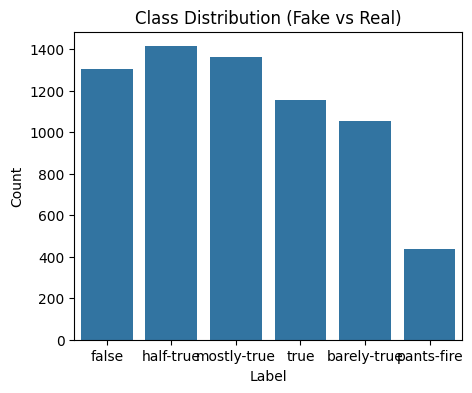

In [83]:
plt.figure(figsize=(5,4))
sns.countplot(x=train_df["label"])
plt.title("Class Distribution (Fake vs Real)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

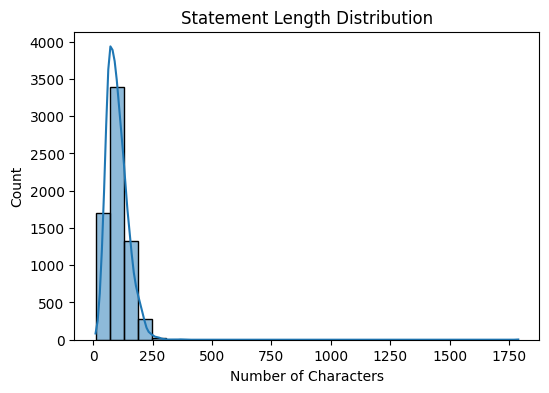

In [54]:
train_df["text_length"] = train_df["statement"].apply(len)

plt.figure(figsize=(6,4))
sns.histplot(train_df["text_length"], bins=30, kde=True)
plt.title("Statement Length Distribution")
plt.xlabel("Number of Characters")
plt.show()

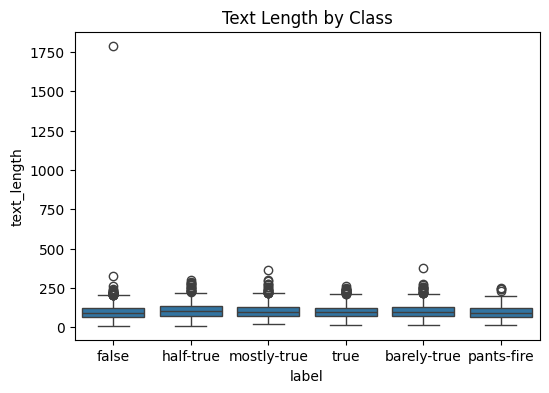

In [55]:
plt.figure(figsize=(6,4))
sns.boxplot(x="label", y="text_length", data=train_df)
plt.title("Text Length by Class")
plt.show()

In [56]:
from collections import Counter

fake_words = " ".join(train_df[train_df["label"]==0]["statement"]).split()
real_words = " ".join(train_df[train_df["label"]==1]["statement"]).split()

fake_common = Counter(fake_words).most_common(10)
real_common = Counter(real_words).most_common(10)

print("Fake News Common Words:", fake_common)
print("Real News Common Words:", real_common)

Fake News Common Words: []
Real News Common Words: []


In [57]:
train_df["target"].value_counts()

,count
target,
1,3929
0,2792


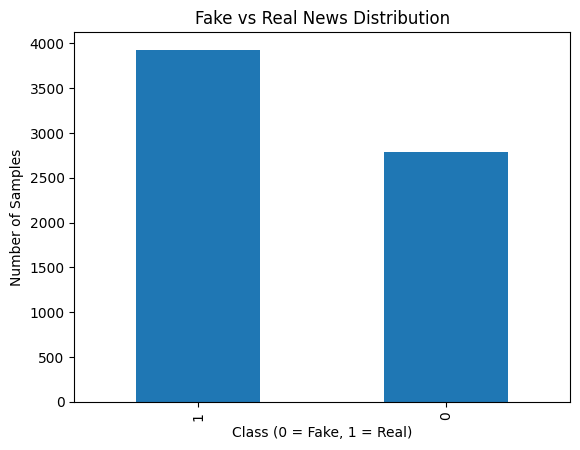

In [58]:
train_df["target"].value_counts().plot(
    kind="bar",
    title="Fake vs Real News Distribution",
    xlabel="Class (0 = Fake, 1 = Real)",
    ylabel="Number of Samples"
)
plt.show()

In [59]:
train_df["text_length"] = train_df["statement"].apply(len)

train_df.groupby("target")["text_length"].mean()

,text_length
target,
0,99.543338
1,103.763553


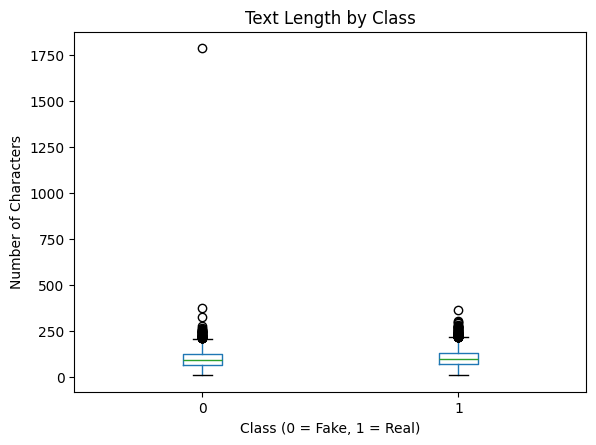

In [60]:
train_df.boxplot(
    column="text_length",
    by="target",
    grid=False
)
plt.title("Text Length by Class")
plt.suptitle("")
plt.xlabel("Class (0 = Fake, 1 = Real)")
plt.ylabel("Number of Characters")
plt.show()

In [61]:
from collections import Counter

fake_words = " ".join(train_df[train_df["target"] == 0]["statement"]).split()
real_words = " ".join(train_df[train_df["target"] == 1]["statement"]).split()

print("Most common FAKE words:", Counter(fake_words).most_common(10))
print("Most common REAL words:", Counter(real_words).most_common(10))

Most common FAKE words: [('the', 2550), ('to', 1275), ('in', 1269), ('of', 1156), ('a', 992), ('says', 724), ('and', 676), ('for', 580), ('that', 550), ('is', 509)]
Most common REAL words: [('the', 4093), ('in', 2204), ('of', 2053), ('to', 1574), ('a', 1352), ('and', 1160), ('says', 823), ('for', 789), ('that', 720), ('is', 685)]


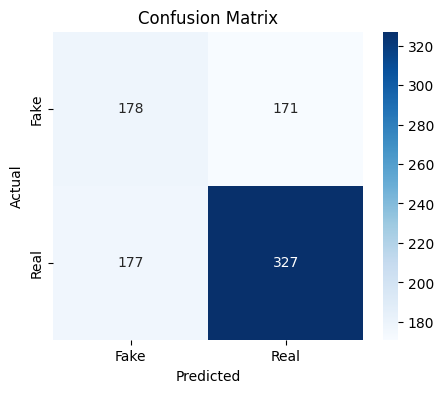

In [81]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake","Real"], yticklabels=["Fake","Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [79]:
print(classification_report(y_test, y_pred, target_names=["Fake","Real"]))


              precision    recall  f1-score   support

        Fake       0.50      0.51      0.51       349
        Real       0.66      0.65      0.65       504

    accuracy                           0.59       853
   macro avg       0.58      0.58      0.58       853
weighted avg       0.59      0.59      0.59       853



In [84]:
feature_names = vectorizer.get_feature_names_out()
coefficients = model.coef_[0]

top_fake = np.argsort(coefficients)[:20]
top_real = np.argsort(coefficients)[-20:]

print("Top words for FAKE news:")
for i in top_fake:
    print(feature_names[i])

print("\nTop words for REAL news:")
for i in top_real:
    print(feature_names[i])

Top words for FAKE news:
obamacare
says
wisconsin
away
government
illegal
women
care law
policies
virginias
says barack
president
obama
know
pass
care
barack obama
gotten
abortion
ken

Top words for REAL news:
washington
twothirds
decades
workers
day
today
ohio
highest
weve
mccain
lowest
half
average
countries
rate
times
debt
months
million
percent


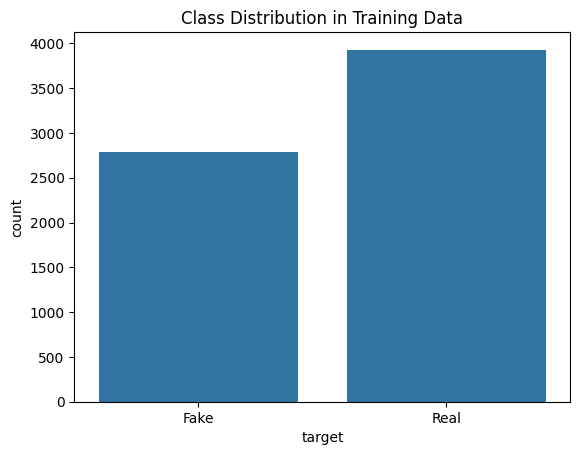

In [88]:
sns.countplot(x="target", data=train_df)
plt.xticks([0,1], ["Fake", "Real"])
plt.title("Class Distribution in Training Data")
plt.show()

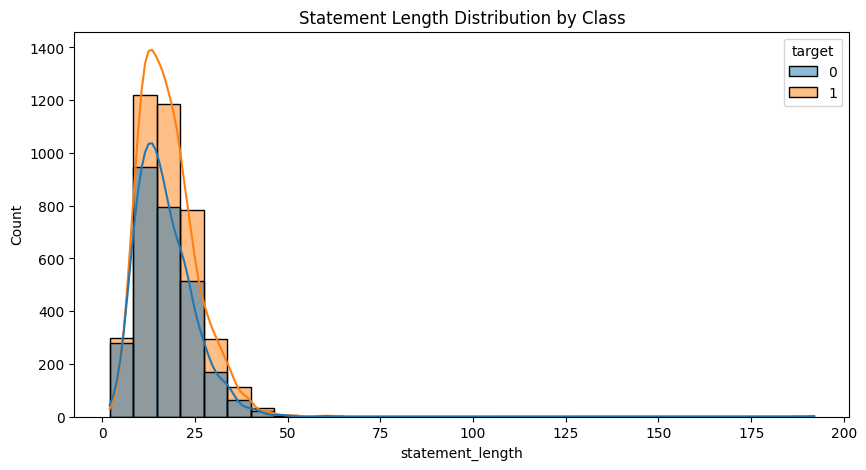

In [89]:
train_df["statement_length"] = train_df["statement"].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
sns.histplot(train_df, x="statement_length", hue="target", bins=30, kde=True)
plt.title("Statement Length Distribution by Class")
plt.show()

In [90]:
from collections import Counter

fake_words = ' '.join(train_df[train_df["target"]==0]["statement"]).split()
real_words = ' '.join(train_df[train_df["target"]==1]["statement"]).split()

fake_common = Counter(fake_words).most_common(20)
real_common = Counter(real_words).most_common(20)

print("Top words in FAKE news:")
print(fake_common)
print("\nTop words in REAL news:")
print(real_common)

Top words in FAKE news:
[('the', 2550), ('to', 1275), ('in', 1269), ('of', 1156), ('a', 992), ('says', 724), ('and', 676), ('for', 580), ('that', 550), ('is', 509), ('on', 415), ('has', 330), ('have', 324), ('are', 289), ('we', 288), ('was', 279), ('percent', 233), ('by', 230), ('obama', 220), ('from', 219)]

Top words in REAL news:
[('the', 4093), ('in', 2204), ('of', 2053), ('to', 1574), ('a', 1352), ('and', 1160), ('says', 823), ('for', 789), ('that', 720), ('is', 685), ('than', 598), ('percent', 594), ('have', 577), ('on', 574), ('has', 551), ('are', 487), ('more', 483), ('we', 432), ('was', 348), ('state', 330)]


In [91]:
"""
Business Use Case:

- Detect fake news automatically before it spreads.
- Help social media platforms moderate content.
- Protect users from misinformation during events like elections, pandemics, or financial news.
- Can be extended to flag suspicious articles in real-time.
"""

'\nBusiness Use Case:\n\n- Detect fake news automatically before it spreads.\n- Help social media platforms moderate content.\n- Protect users from misinformation during events like elections, pandemics, or financial news.\n- Can be extended to flag suspicious articles in real-time.\n'

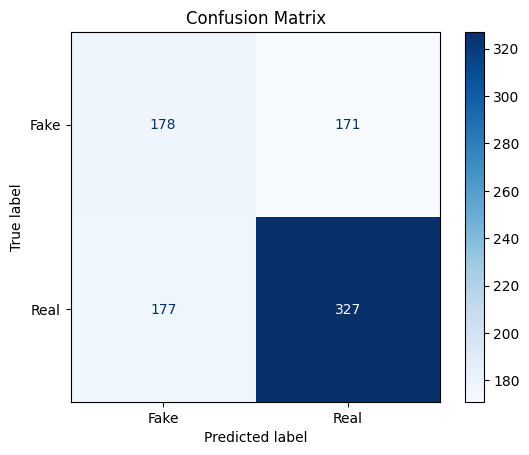

In [93]:
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [94]:
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Fake", "Real"]))

Classification Report:

              precision    recall  f1-score   support

        Fake       0.50      0.51      0.51       349
        Real       0.66      0.65      0.65       504

    accuracy                           0.59       853
   macro avg       0.58      0.58      0.58       853
weighted avg       0.59      0.59      0.59       853



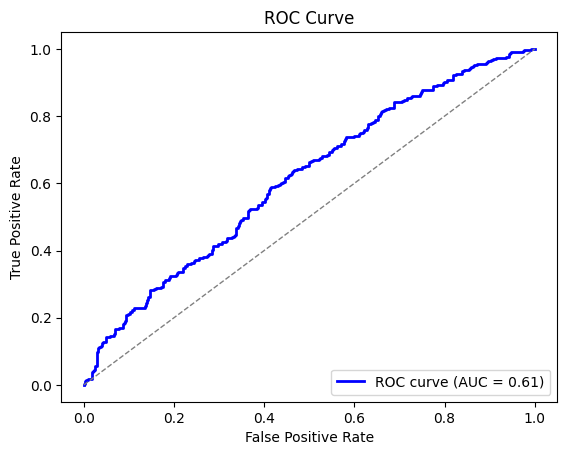

In [96]:
y_prob = model.predict_proba(X_test)[:,1]  # Probability of class 1 (Real)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

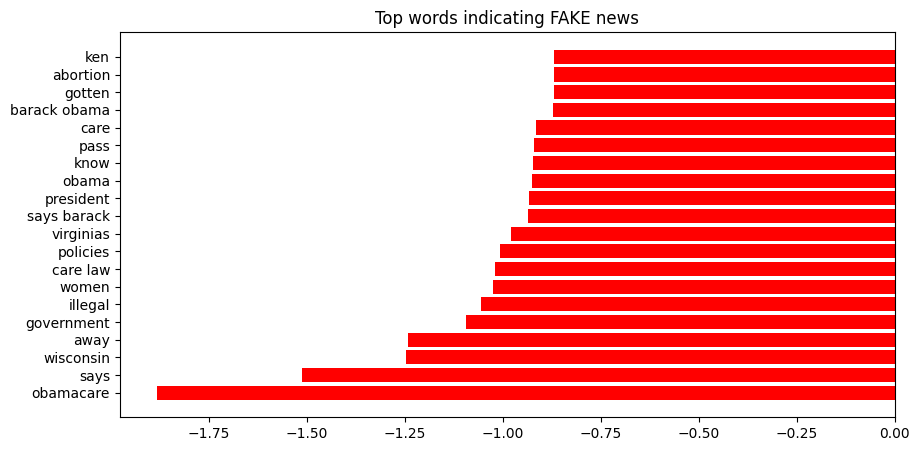

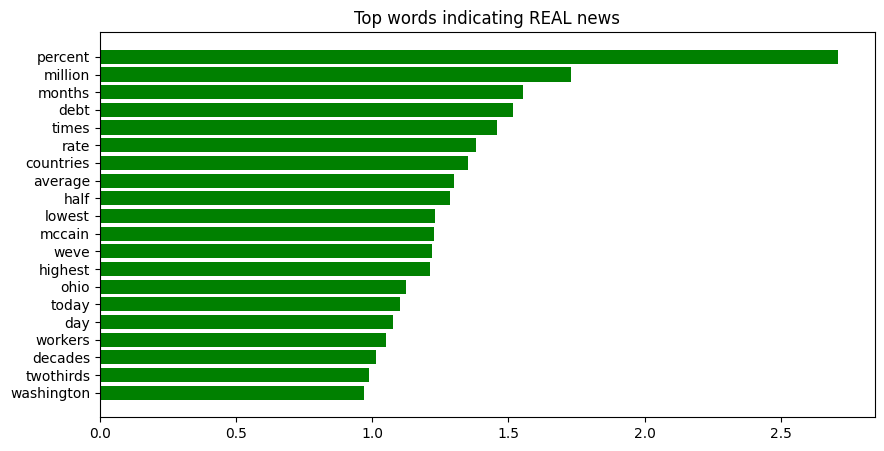

In [97]:
feature_names = vectorizer.get_feature_names_out()
coefficients = model.coef_[0]

top_fake_idx = np.argsort(coefficients)[:20]
top_real_idx = np.argsort(coefficients)[-20:]

plt.figure(figsize=(10,5))
plt.barh([feature_names[i] for i in top_fake_idx], coefficients[top_fake_idx], color='red')
plt.title("Top words indicating FAKE news")
plt.show()

plt.figure(figsize=(10,5))
plt.barh([feature_names[i] for i in top_real_idx], coefficients[top_real_idx], color='green')
plt.title("Top words indicating REAL news")
plt.show()
